In [22]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from glob import glob
import os
from astropy.visualization import ZScaleInterval, ImageNormalize, LogStretch, AsymmetricPercentileInterval
import h5py 
from astropy.nddata import CCDData
from PIL import Image
from datetime import datetime, timedelta
from ccdproc import ImageFileCollection
import pandas as pd
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import AutoLocator, AutoMinorLocator, FixedLocator, FixedFormatter, LogLocator
import cmcrameri.cm as cmcm

In [2]:
video_frame_fnames = sorted(glob("../../sav/Eclipse/Video/frame*.jpg"))
video_frame_fnames = video_frame_fnames[40:190]

In [3]:
video_frame_cube = np.zeros((1080,1920,3,190-40),dtype="uint8")
for ii, video_frame_fname in enumerate(video_frame_fnames):
    with Image.open(video_frame_fname) as im:
        video_frame_cube[:,:,:,ii] = np.asarray(im)

video_vertical_slice =  slice(390,710)
video_horizontal_slice = slice(746,1160)
video_frame_cube = video_frame_cube[video_vertical_slice,video_horizontal_slice,:,:]

In [4]:
video_time_array = np.arange(datetime(2017,8,21,17,45,21),datetime(2017,8,21,17,47,51),timedelta(seconds=1)).astype(datetime)
video_time_array.shape

(150,)

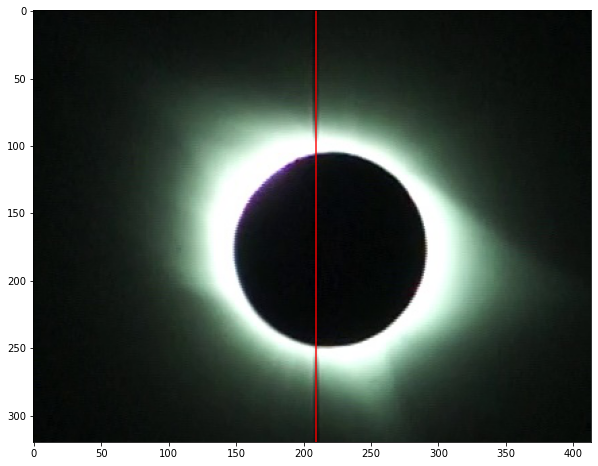

In [5]:
fig, ax = plt.subplots(figsize=(10,8))
ax.imshow(video_frame_cube[:,:,:,10])
slit_pos = 209.4
ax.axvline(slit_pos,color="red",lw=2,alpha=0.7)

9

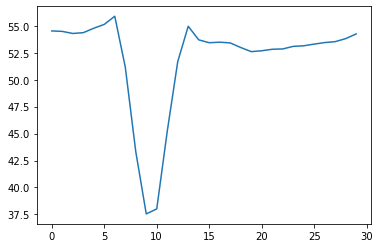

In [6]:
plt.plot(np.mean(video_frame_cube[:,200:230,0,10],axis=0))
np.argmin(np.mean(video_frame_cube[:,200:230,0,10],axis=0))

In [7]:
green_path = "../../src/EclipseSpectra2017/MikesData/VaderEclipseDayGreen2017aug21/"
red_path = "../../src/EclipseSpectra2017/MikesData/VaderEclipseDayRed2017aug21/"

totality_green_im_collection = ImageFileCollection(green_path,
                        glob_include="TotalitySequence*.fit")
totality_green_df = totality_green_im_collection.summary.to_pandas()
totality_green_df["date-obs"] = pd.to_datetime(totality_green_df["date-obs"])

totality_red_im_collection = ImageFileCollection(red_path,
                        glob_include="TotalitySequence*.fit")
totality_red_df = totality_red_im_collection.summary.to_pandas()
totality_red_df["date-obs"] = pd.to_datetime(totality_red_df["date-obs"])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:87: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


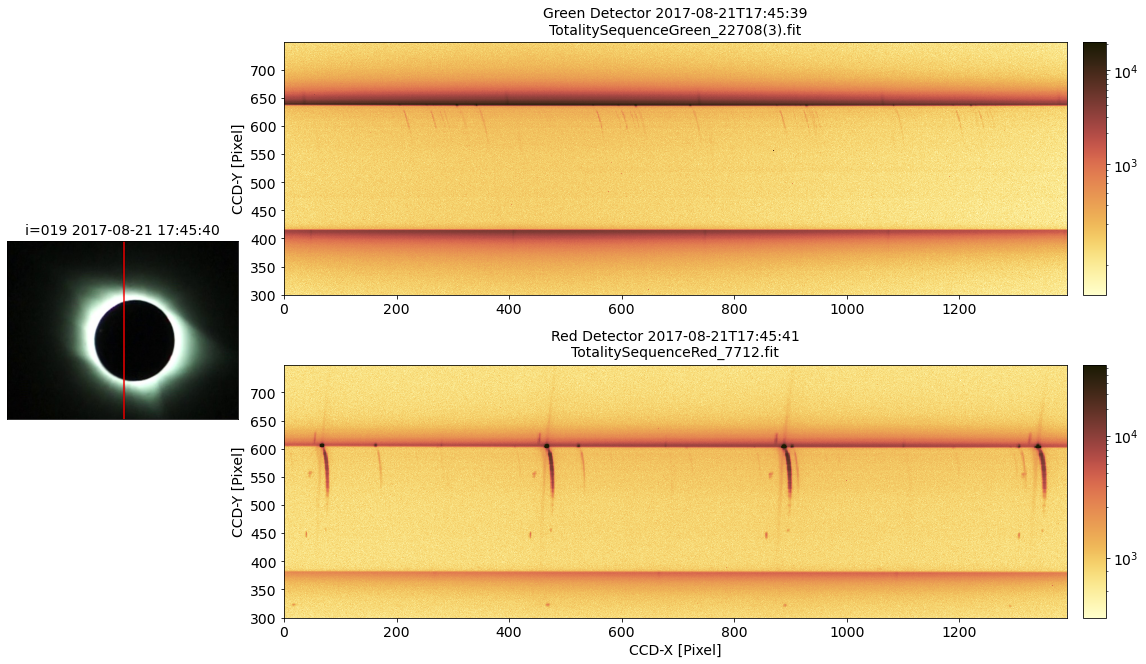

In [44]:
for ii in range(19,20):
    fig = plt.figure(figsize=(16,10),constrained_layout=False)

    # gs0 = fig.add_gridspec(1,2,width_ratios=[1.5,3],right=0.93,left=0.01,top=0.99,bottom=0.03)
    # ax_video = fig.add_subplot(gs0[0])
    # gs1 = gs0[1].subgridspec(2, 1,hspace=0.02)
    # ax_green = fig.add_subplot(gs1[0])
    # ax_red = fig.add_subplot(gs1[1])

    gs_left = 0.01
    gs_right = 0.93
    gs_top = 0.95
    gs_bottom = 0.06

    gs = fig.add_gridspec(nrows=10, ncols=4, left=gs_left, right=gs_right,bottom=gs_bottom,top=gs_top,
                        hspace=0.08)
    ax_video = fig.add_subplot(gs[:, :1])
    ax_green = fig.add_subplot(gs[:5, 1:])
    ax_red = fig.add_subplot(gs[5:, 1:])

    ax_video.imshow(video_frame_cube[:,:,:,ii])
    ax_video.axvline(slit_pos,color="red",lw=2,alpha=0.7)
    ax_video.text(0.5,1.02,"i={:03d} {}".format(ii,video_time_array[ii]),transform=ax_video.transAxes,fontsize=14,ha="center",va="bottom")

    ax_video.axis("scaled")

    ax_video.tick_params(left=False,bottom=False,labelleft=False,labelbottom=False)

    green_nearest_fname = totality_green_df.loc[(totality_green_df['date-obs'] 
                - video_time_array[ii]).abs().idxmin(),"file"]
    red_nearest_fname = totality_red_df.loc[(totality_red_df['date-obs'] 
                - video_time_array[ii]).abs().idxmin(),"file"]

    green_frame = CCDData.read(os.path.join(green_path,green_nearest_fname),unit="adu")
    red_frame = CCDData.read(os.path.join(red_path,red_nearest_fname),unit="adu")

    green_image = green_frame.data[300:750,:]/green_frame.header["EXPTIME"]
    red_image = red_frame.data[300:750,:]/red_frame.header["EXPTIME"]

    norm_green = ImageNormalize(green_image,stretch=LogStretch())
    norm_red = ImageNormalize(red_image,stretch=LogStretch())

    im_green = ax_green.pcolormesh(np.arange(green_frame.header["NAXIS1"]),np.arange(450)+300,
                        green_image,cmap=cmcm.lajolla,norm=norm_green,shading='auto',rasterized=True)

    im_red = ax_red.pcolormesh(np.arange(red_frame.header["NAXIS1"]),np.arange(450)+300,
                        red_image,cmap=cmcm.lajolla,
                        norm=norm_red,shading='auto',rasterized=True)

    ax_green.text(0.5,1.02,"Green Detector {}\n{}".format(green_frame.header["DATE-OBS"],green_nearest_fname),
        transform=ax_green.transAxes,va="bottom",ha="center",fontsize=14)

    ax_red.text(0.5,1.02,"Red Detector {}\n{}".format(red_frame.header["DATE-OBS"],red_nearest_fname),
        transform=ax_red.transAxes,va="bottom",ha="center",fontsize=14)

    clb_green_ax = inset_axes(ax_green,width="3%",height= "100%",loc='lower left',
            bbox_to_anchor=(1.02, 0., 1, 1),
            bbox_transform=ax_green.transAxes,
            borderpad=0)
    clb_green = plt.colorbar(im_green,pad = 0.05,orientation='vertical',
                ax=ax_green,cax=clb_green_ax)

    clb_red_ax = inset_axes(ax_red,width="3%",height= "100%",loc='lower left',
            bbox_to_anchor=(1.02, 0., 1, 1),
            bbox_transform=ax_red.transAxes,
            borderpad=0)
    clb_red = plt.colorbar(im_red,pad = 0.05,orientation='vertical',
                ax=ax_red,cax=clb_red_ax)
    
    for ax_ in (ax_green, ax_red):
        ax_.axis("scaled")
        ax_.tick_params(labelsize=14)

    for ax_ in (clb_green_ax, clb_red_ax):
        ax_.yaxis.set_major_locator(FixedLocator([1e2,1e3,1e4,1e5])) 
        ax_.yaxis.set_major_formatter(FixedFormatter((r"10^2",r"$10^3$",r"$10^4$",r"$10^5$")))
        y_minor = LogLocator(base = 10.0, subs = np.arange(1.0, 10.0) * 0.1, numticks = 10)
        ax_.yaxis.set_minor_locator(y_minor)
        # ax_.yaxis.set_minor_locator(AutoMinorLocator(10))
        ax_.tick_params(labelsize=14)
        
    
    ax_green.set_ylabel("CCD-Y [Pixel]",fontsize=14)
    ax_red.set_xlabel("CCD-X [Pixel]",fontsize=14)
    ax_red.set_ylabel("CCD-Y [Pixel]",fontsize=14)

    plt.tight_layout()

    plt.savefig(fname=os.path.join("../../sav/Eclipse/Video_Comb/","Video_Comb_test.png".format(ii)),format="png",
                dpi=120)
